# Technial Assessment 
### Evan Cernea
### January 27th, 2019


In [65]:
library(ggplot2)
library(dplyr)
library(caret)
library(MASS)
options(scipen=999)

In [4]:
plotTheme <- function(base_size = 12) {
  theme(
    text = element_text( color = "black"),
    plot.title = element_text(size = 18,colour = "black"),
    plot.subtitle = element_text(face="italic"),
    plot.caption = element_text(hjust=0),
    axis.ticks = element_blank(),
    panel.background = element_blank(),
    panel.grid.major.y = element_line("grey80", size = 0.1),
    panel.grid.minor = element_blank(),
    strip.background = element_rect(fill = "grey80", color = "white"),
    strip.text = element_text(size=12),
    axis.title = element_text(size=8),
    axis.text = element_text(size=8),
    axis.title.y = element_text(size=12),
    plot.background = element_blank(),
    legend.background = element_blank(),
    legend.title = element_text(colour = "black", face = "italic"),
    legend.text = element_text(colour = "black", face = "italic"),
    axis.ticks.y = element_line(color="grey70"),
    axis.text.x =  element_blank(),
    axis.title.x = element_blank(),
    axis.ticks.x = element_blank())
}


## Part One: Data Cleaning and Variable Exploration

### Selecting Variables

I first loaded the data and selected only the columns designated in the assessment. When loading the data, I made sure to transform any blank cells into NAs.

In [5]:
test_data <- read.csv("C:/Users/Evan Cernea/Downloads/loan.csv/loan.csv", header=T, na.strings=c("","NA"))
test_selected <- test_data %>% dplyr::select('loan_amnt', 'funded_amnt', 
                                             'term', 'int_rate', 'grade', 'annual_inc', 'issue_d', 'dti', 
                                             'revol_bal', 'total_pymnt', 'loan_status')

### Null and Zero Variables

After selecting the designated columns, I examined which of those columns had either NA or 0 values. I first examined NA values.

In [6]:
test_selected %>% summarise_all(funs(sum(is.na(.))))

loan_amnt,funded_amnt,term,int_rate,grade,annual_inc,issue_d,dti,revol_bal,total_pymnt,loan_status
0,0,0,0,0,4,0,0,0,0,0


There are only four `NA` values and they all appear in the `annual_inc` column. I decided to remove these rows from the data because 4 rows only represents less than a thousandth percent of total observations. 

In [7]:
test_selected <- test_selected %>% na.omit()

After removing the NAs, I examined which columns had `0` values.

In [8]:
colSums(test_selected == 0)

loan_amnt funded_amnt        term    int_rate       grade  annual_inc 
          0           0           0           0           0           2 
    issue_d         dti   revol_bal total_pymnt loan_status 
          0         451        3398       17759           0

The columns that include 0 values are `annual_inc`, `dti`, `revol_bal`, and `total_pymnt`. It is feasible to have no revolving balance if you have paid off your loans or no payment if you haven't paid any loans. Having an annual income of zero, or having a debt-to-income ratio of zero (which also means zero income) would be suspect when it comes to loan repayment. Since there were a total 453 entries, which represents a fraction of a percent of the total observations, I removed these entries as well.

In [9]:
test_selected <- test_selected %>% filter(annual_inc > 0, dti > 0)

### Removing Outliers

I then examine the distribution of the numeric variables to see if there were any outliers. The numeric variables are
* `loan_amnt`
* `funded_amnt`
* `int_rate`
* `annual_inc`
* `dti`
* `revol_bal`
* `total_pymnt`

I decided for variables `revol_bal` and `total_pymnt` it was acceptable to keep outliers because we are analyzing debt and loan repayment, so it is useful to have as much information about payment as possible.

There were notable outliers in the variables `annual_inc` and `dti`. See the boxplots of the variable distribution below with summary statistics. Outliers are represented by red stars:

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1200   45000   65000   75034   90000 9500000 

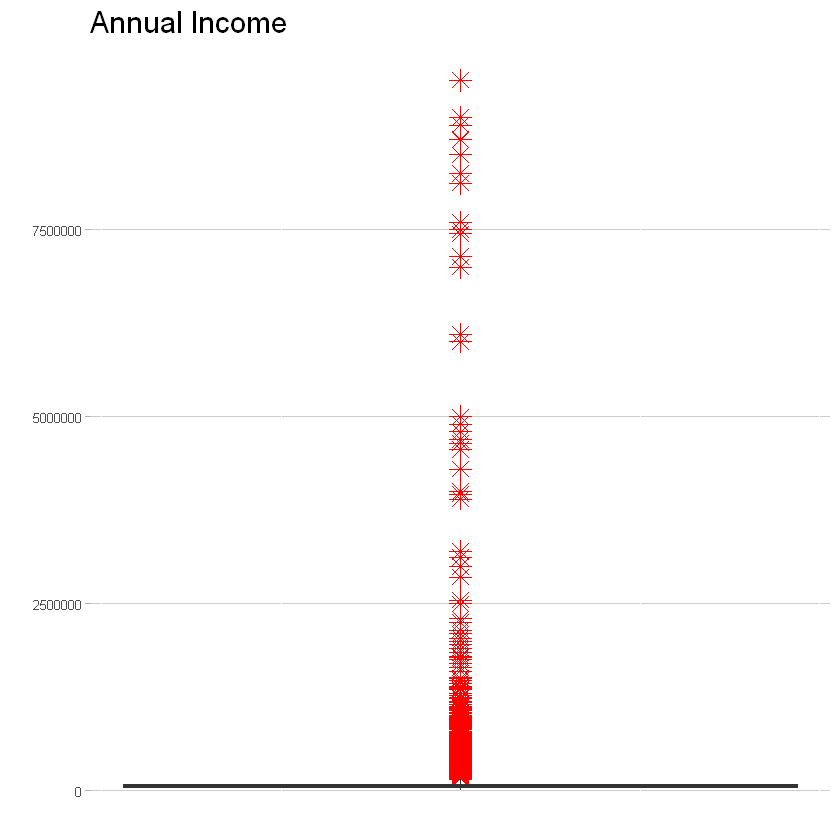

In [10]:
ggplot(data=test_selected, aes(y=test_selected$annual_inc)) + geom_boxplot(outlier.colour="red", outlier.shape=8,
                outlier.size=4) + plotTheme() + labs(y="",title="Annual Income")
summary(test_selected$annual_inc)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.01   11.92   17.66   18.14   23.95 1092.52 

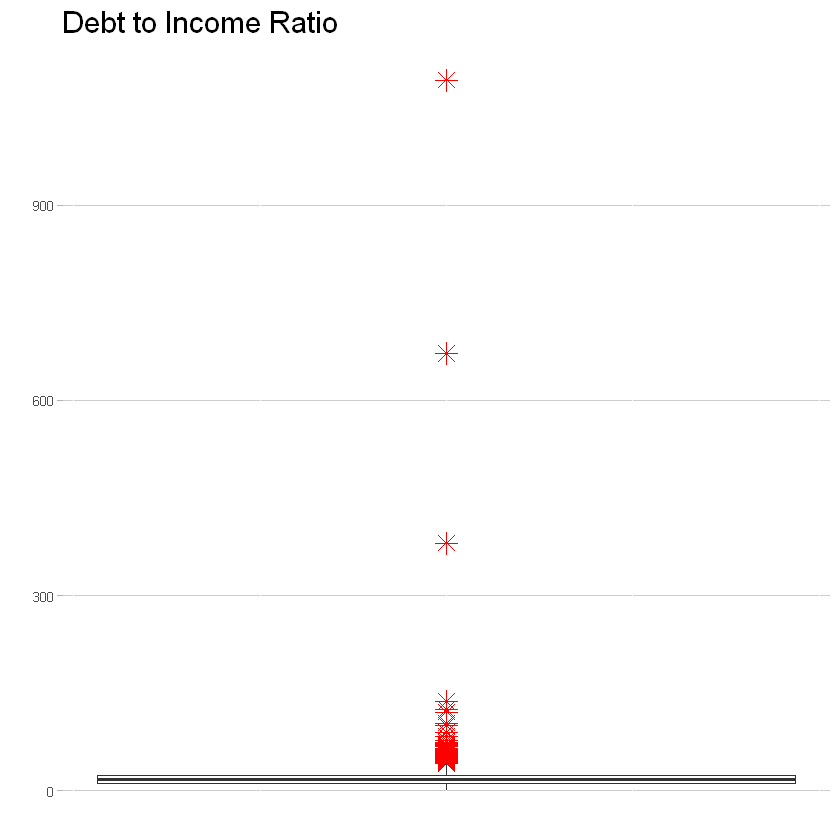

In [11]:
ggplot(data=test_selected, aes(y=test_selected$dti)) + geom_boxplot(outlier.colour="red", outlier.shape=8,
                outlier.size=4) + plotTheme() + labs(y="",title="Debt to Income Ratio")
summary(test_selected$dti)

It is clear with both distributions that there is a tight distribution on the bottom, then some outliers just above the standard distribution. I wanted to further examine the outliers before discarding them wholesale from the dataset. I removed them using the code below, and then examined the distribution of the outliers starting with `annual_inc`:

In [12]:
inc_out <- boxplot(test_selected$annual_inc, plot=FALSE)$out %>% as.data.frame()
summary(inc_out)

       .          
 Min.   : 157525  
 1st Qu.: 175000  
 Median : 200000  
 Mean   : 235543  
 3rd Qu.: 247000  
 Max.   :9500000  

What these summary statistics show us is that 75% of the outliers for annual income fall between 157525 dollars and 247000 dollars, which is a relatively tight distribution. Instead of removing all ~39,000 outliers, which still only represents 4% of the data, I decided to keep all outliers less than $250000 which leaves 877081 observations in the data set. The updated graph below shows the much tighter distribution of outliers.

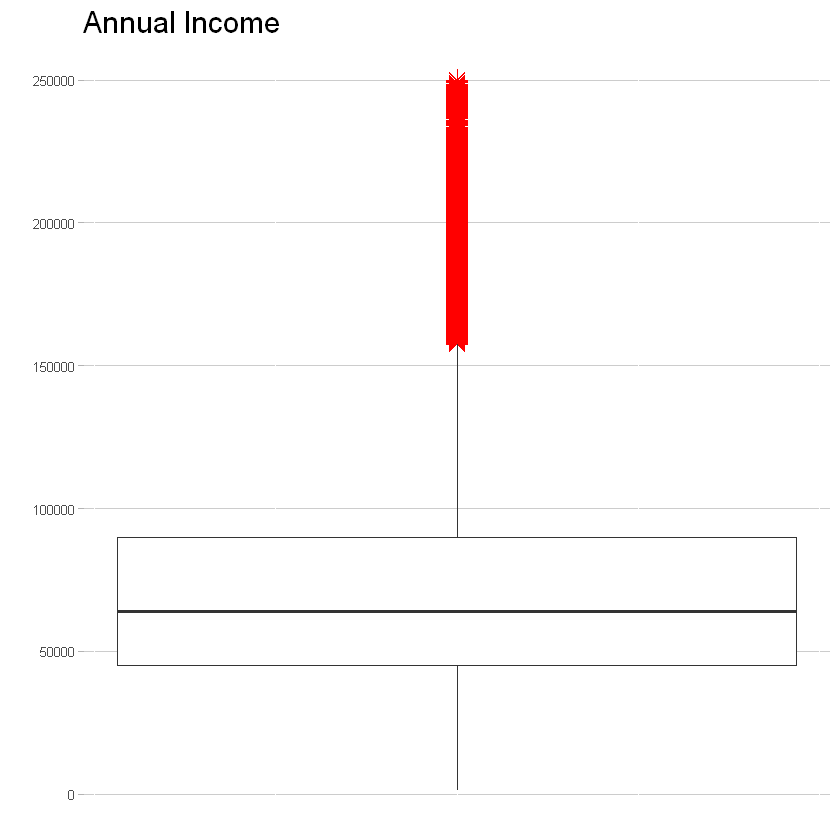

In [13]:
test_selected <- test_selected  %>% filter(annual_inc < 250000)
ggplot(data=test_selected, aes(y=test_selected$annual_inc)) + geom_boxplot(outlier.colour="red", outlier.shape=8,
                outlier.size=4) + plotTheme() + labs(y="",title="Annual Income")

I wanted to check if removing the `annual_inc` would deal with the `dti` outliers. I repeat the same process to examine the `dti` outliers:

In [14]:
dti_out <- boxplot(test_selected$dti, plot=FALSE)$out %>% as.data.frame()
summary(dti_out)
nrow(dti_out)

       .          
 Min.   :  42.03  
 1st Qu.:  45.10  
 Median :  52.80  
 Mean   :  84.50  
 3rd Qu.:  68.36  
 Max.   :1092.52  

[1] 79

Here, there are only 79 outliers, so I feel safe removing them wholesale, as seen below:

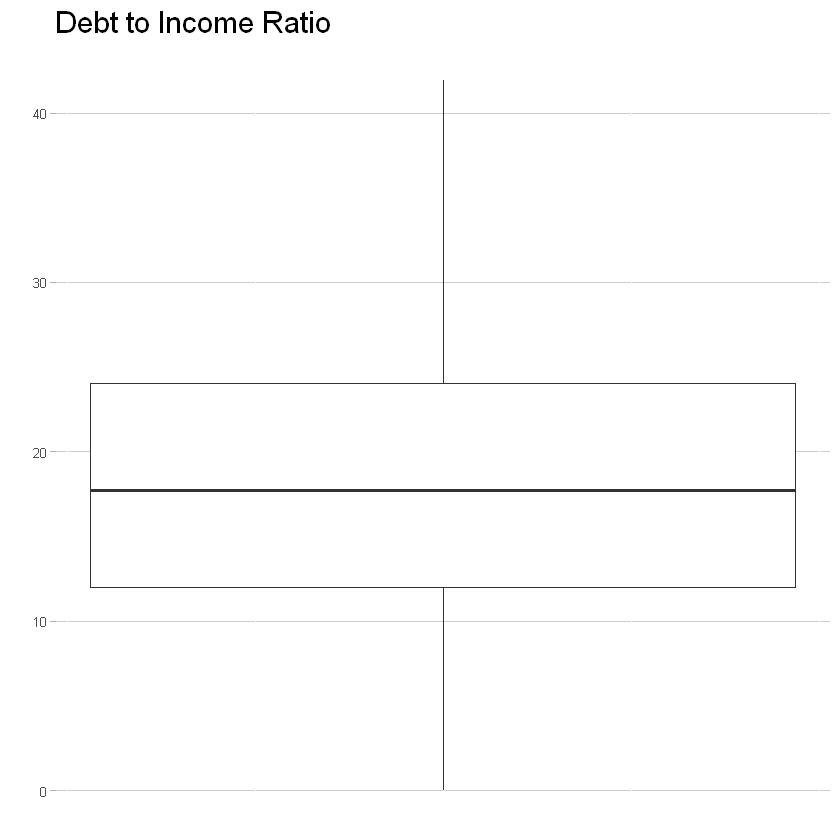

In [15]:
test_selected <- test_selected  %>% filter(dti < 42.03)
ggplot(data=test_selected, aes(y=test_selected$dti)) + geom_boxplot(outlier.colour="red", outlier.shape=8,
                outlier.size=4) + plotTheme() + labs(y="",title="Debt to Income Ratio")

I now feel comfortable moving onto the analysis questions.

## Part Two: Business Analysis

### Using applicable data

The problem asks to analyze 36 Month long leases where 36 months or more data is available. This means doing some filtering to only be looking at the variable where `term` is equal to 36 months. 

We do not need to do any date-based filtering, since the last loan was issued in 2015, which was over 36 months ago as of earlier this month.

In [16]:
three_year_term <- test_selected  %>% filter(term == " 36 months")

### Question One

I will then create a categorical variable to determine loan payment. If `total_pymnt` is equal to `loan_amnt`, then we will consider the loan paid in full. I graphed the loans that did not default compared to those that did, and calculated that __30.33% of loans were paid in full in the 36 month period.__

[1] "30.33%"

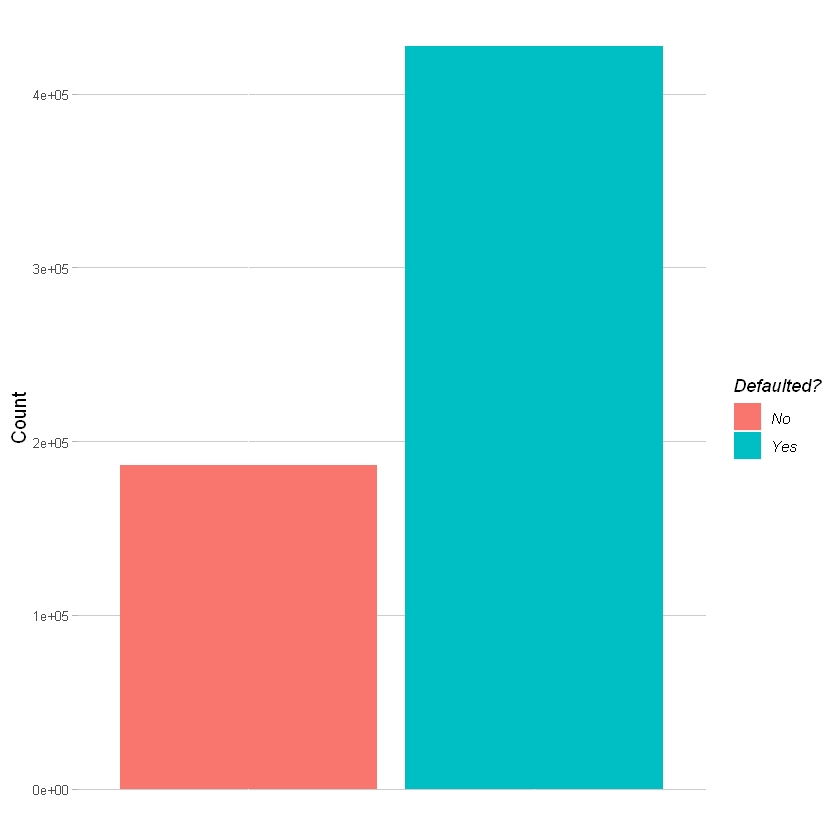

In [17]:
three_year_term <- three_year_term %>% mutate(default = loan_amnt-total_pymnt)  %>% 
mutate(default = ifelse(default > 0, "Yes", "No"))  %>% 
mutate(default_number = ifelse(default == "Yes", 0, 1))
ggplot(three_year_term, aes(x=default,fill=default)) + geom_bar() + plotTheme() + labs(y="Count", fill="Defaulted?") 
pct_paid = paste0(round(sum(three_year_term$default_number)/nrow(three_year_term) * 100, 2), "%")
pct_paid

### Question Two

I then needed to learn how the organizing by grade and year issued impacted the default rate. This first required me to make a year variable from the `issue_d` variable.

In [18]:
three_year_term <- three_year_term  %>% mutate(year = substring(issue_d, 5,9))

I then grouped the data by year and grade and created a rate of default by finding 1 minus the percent of `default_number` multiplied by 100. I also included the count of how many loans were issued in that year to each grade, for context.

In [19]:
three_year_term %>% group_by(grade,year) %>% summarise(count = n(), 
                                                       default_rate =  1 - sum(default_number)/count) %>% 
arrange(desc(default_rate))  %>% 
mutate(default_rate = paste0(round(default_rate*100,2),"%"))

grade,year,count,default_rate
A,2015,68602,95.57%
B,2015,90602,94.89%
C,2015,76780,93.19%
F,2015,1358,92.34%
D,2015,32427,92.29%
E,2015,9374,92.21%
G,2015,245,91.84%
F,2014,1951,76.88%
G,2014,173,76.88%
A,2014,34724,75.39%


We can see that loans issued a __A Grade in 2015__ had the highest rate of default

### Question 3

I went through a similar process to find which grade and year combination had the highest annualized rate of return on average. I first created an annualized rate of return column using the formula provided. I then found the average by grade and year. __Loans issued a G grade in 2012 had the highest mean annualized rate of return__

In [20]:
three_year_term <- three_year_term  %>% mutate(ann_RoR = ((total_pymnt / funded_amnt) ^ (1/3)) - 1)
three_year_term %>% group_by(grade,year) %>% summarise(mean_ann_RoR = mean(ann_RoR)) %>% arrange(desc(mean_ann_RoR))  %>%
mutate(mean_ann_RoR = paste0(round(mean_ann_RoR*100,2),"%"))


grade,year,mean_ann_RoR
G,2012,3.55%
E,2012,3.23%
F,2012,2.85%
A,2007,2.6%
D,2012,2.39%
B,2012,2.34%
A,2008,2.34%
E,2011,2.33%
C,2010,2.23%
F,2011,2.23%


## Part Three

I now need to build a model to predict wheter or not to invest in these loans. Since these investments are made at the beginning, we will not know the `total_pymnt` or `loan_status` columns, so they should be removed from our model building.

We also need to create a training and test set for a logistic model to evalue its effectiveness. I remove the columns and then create a training and test set below:

In [21]:
regression_data <- three_year_term %>% dplyr::select('loan_amnt', 'funded_amnt', 
                                             'int_rate', 'grade', 'annual_inc', 'issue_d', 'dti', 
                                             'revol_bal', 'default_number')
regression_data$default_number <- as.factor(as.character(regression_data$default_number))
partition <- createDataPartition(regression_data$default_number, p=.75,list=F)
trainSet <- regression_data[partition,]
testSet <- regression_data[-partition,]

I then created a logistic binomial regression with all of the variables in the training set.

In [60]:
## Logistic regression
lreg<-glm(default_number~.,data=trainSet,family="binomial")

Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"

I used this model to predict on the test set if each `default_number` was either `0`, meaning default, or `1`, meaning paid in full. I decided to use a cutoff value of .5 -- if the model predicts that there's above a 50% chance that the loan did not default, then I would classify it as a not defaulted loan. I then compared this to the actual status of its default to see how many predictions were correct versus incorrect.

In [61]:
testSet$defaultPred <- predict(lreg, newdata=testSet,type="response")


  Correct Incorrect 
   129285     24160 

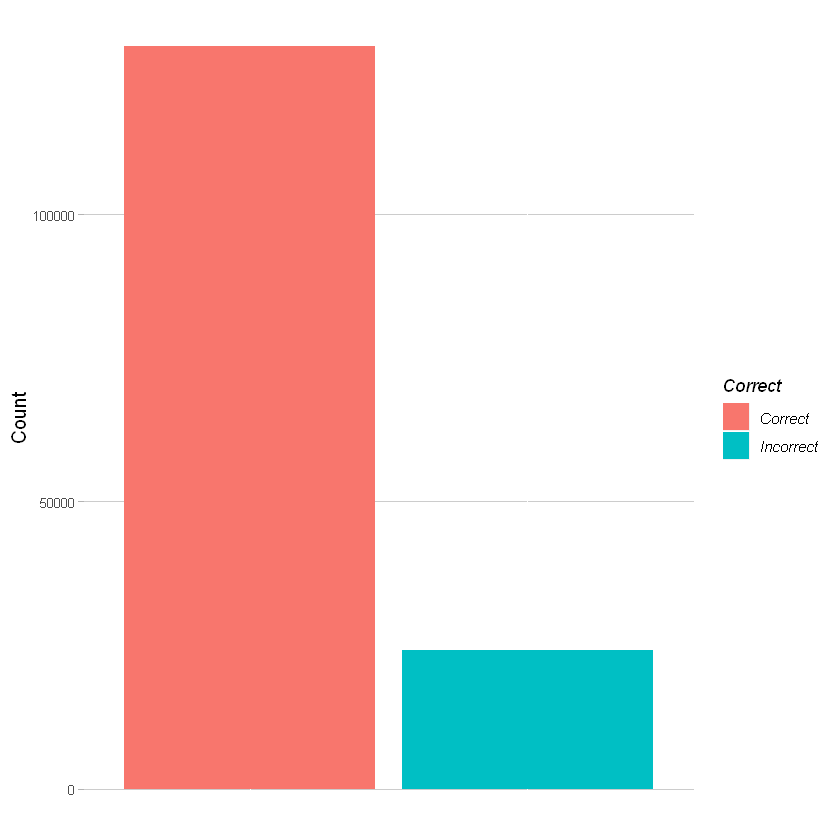

In [67]:
testSet$default_number <- as.numeric(as.character(testSet$default_number))
testSet <- testSet  %>% mutate(defaultPred = ifelse(defaultPred > .5, 1, 0),
                                                    correct = ifelse(default_number==defaultPred, "Correct", "Incorrect")) 
ggplot(testSet, aes(x=correct,fill=correct)) + geom_bar() + plotTheme() + labs(y="Count",fill="Correct")
table(testSet$correct)

I also wanted to see how the model made its errors. I created a confusion matrix, showing where there were false positives (meaning the loan did not default but the model predicted it did), false negatives (meaning the loan did default but the model predicted it didn't), true positives, and true negatives. 

In [74]:
testSet$confuseClassification = ifelse((testSet$defaultPred == 0 & testSet$default_number == 0), "True Negative", 
                                       ifelse((testSet$defaultPred == 1 & testSet$default_number == 1), "True Positive", 
                                              ifelse((testSet$defaultPred == 0 & testSet$default_number == 1), "False Negative", 
                                                     "False Positive")))
testSet  %>% group_by(default_number,confuseClassification)  %>% summarise(count=n())

default_number,confuseClassification,count
0,False Positive,6062
0,True Negative,100840
1,False Negative,18098
1,True Positive,28445


As we can see, the model has a high rate of false negatives when the cutoff is a 50% probabilty. From an investment standpoint, this is a problem -- a false negative in this instance means we would invest in a loan we predicted to be paid in full but actually defaults. We would need to either improve the model or its cutoff to reduce the number of false negatives.

This model, with a randomly chosen cutoff, has a very high rate of success in predicting overall default rate on the test set, which is data it did not see when the model was learning what was a default versus not. I could improve this model with better machine learning techniques or a more refined cutoff. 